# Calculate bubble parameters for image using a pre-fine tuned model

## Step 1: Connect to a **GPU** Runtime

1. Click the drop-down icon beside the 'Connect' button in the top-right area of this page.
2. Click 'Change runtime type'
3. Select 'T4 GPU' or any other GPU-based runtime
4. Click 'Save'

## Step 2: Loading the model
Run the below code blocks one by one

In [ ]:
!pip install gdown
import gdown
url = 'https://drive.google.com/uc?id=1Zejm-ytk8-8VExwpe4um-P6QeYyPVLv9'
# url = 'https://drive.google.com/uc?id=1INDjxHgrdafAcRayfeEE6wlA9_d4-zc8'
output = 'best_mrcnn.pth'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Zejm-ytk8-8VExwpe4um-P6QeYyPVLv9
From (redirected): https://drive.google.com/uc?id=1Zejm-ytk8-8VExwpe4um-P6QeYyPVLv9&confirm=t&uuid=7702328a-65fb-42b5-8345-a425c57c257f
To: /content/best_mrcnn.pth
100%|██████████| 856M/856M [00:13<00:00, 63.4MB/s]


'best_mrcnn.pth'

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-_0xvvuqm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-_0xvvuqm
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9131ce0e5bc0c89904541bc0355d933ccd6acbfb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="CFBicWjCGnntSJAbyLbj")
project = rf.workspace("indian-institute-of-technology-guwahati").project("btp_25")
version = project.version(1)
dataset = version.download("coco")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BTP_25-1 in coco:: 100%|██████████| 370/370 [00:00<00:00, 4200.15it/s]


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, f"{dataset.location}/train/_annotations.coco.json", f"{dataset.location}/train")
register_coco_instances("my_dataset_val", {}, f"{dataset.location}/valid/_annotations.coco.json", f"{dataset.location}/valid")
register_coco_instances("my_dataset_test", {}, f"{dataset.location}/test/_annotations.coco.json", f"{dataset.location}/test")


In [ ]:
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = (500, 1000)
cfg.SOLVER.GAMMA = 1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.TEST.EVAL_PERIOD = 500
cfg.MODEL.WEIGHTS = "best_mrcnn.pth"

## Step 3: Set threshold

Set appropriate threshold(sensitivity) for detection bubbles and run the code block. <br>
The value should be between 1 and 0. <br>
0 is most sensitive and 1 is least.<br>
Default value is 0.7

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# cfg.MODEL.DEVICE = "cpu"  # Use GPU if available, otherwise "cpu"
predictor = DefaultPredictor(cfg)

[11/09 20:13:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from best_mrcnn.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import time

evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")

val_loader = build_detection_test_loader(cfg, "my_dataset_test")

metrics = inference_on_dataset(predictor.model, val_loader, evaluator)


WARNING [11/03 17:54:53 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [11/03 17:54:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/03 17:54:53 d2.data.datasets.coco]: Loaded 36 images in COCO format from /content/BTP_25-1/test/_annotations.coco.json
[11/03 17:54:54 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   bubble   | 0            |   bubble   | 1978         |
|            |              |            |              |
|   total    | 1978         |            |              |
[11/03 17:54:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/03 17:54:54 d2

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


[11/03 17:55:02 d2.evaluation.evaluator]: Inference done 11/36. Dataloading: 0.0096 s/iter. Inference: 0.2007 s/iter. Eval: 0.0719 s/iter. Total: 0.2823 s/iter. ETA=0:00:07
[11/03 17:55:07 d2.evaluation.evaluator]: Inference done 36/36. Dataloading: 0.0042 s/iter. Inference: 0.1807 s/iter. Eval: 0.0362 s/iter. Total: 0.2212 s/iter. ETA=0:00:00
[11/03 17:55:07 d2.evaluation.evaluator]: Total inference time: 0:00:06.960724 (0.224539 s / iter per device, on 1 devices)
[11/03 17:55:07 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.180707 s / iter per device, on 1 devices)
[11/03 17:55:07 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/03 17:55:07 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[11/03 17:55:07 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[11/03 17:55:07 d2.evaluation.f

In [ ]:
print(metrics)

OrderedDict([('bbox', {'AP': 55.20920629805751, 'AP50': 78.53651546048015, 'AP75': 63.57250226792798, 'APs': 41.007525034252104, 'APm': 65.17360480779732, 'APl': 75.27249240136086, 'AP-bubble': 55.20920629805751}), ('segm', {'AP': 55.117736808025384, 'AP50': 78.58408859675829, 'AP75': 64.2493357127912, 'APs': 41.23965414054609, 'APm': 64.83306941816235, 'APl': 73.5054391163693, 'AP-bubble': 55.117736808025384})])


## Step 5: Results
Run the below code blocks to get:
1. Number of bubbles
2. Mean area of bubbles
3. Mean diameter of bubbles
4. Visualization of bubble segmentation
5. List of individual bubble diameter and areas
for each uploaded image.

The code can be changed to get desired parameters from the image

---
Note:
1. Units for area and diameter are in mm and mm^2, unless the scaling line is commented out which makes units as  pixels.
2. The formula used for calculating bubble diameter is: 2*sqrt(area/pi)



In [ ]:
image_dim_mm = 20.7 # physical dimension (height or width) of the image in mm

In [ ]:

import os
import cv2

def read_first_image_in_folder(folder_path):
  if not os.path.exists(folder_path):
    print(f"Error: Folder '{folder_path}' not found.")
    return None

  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
      try:
        image = cv2.imread(file_path)
        if image is not None:
          return image
      except Exception as e:
        print(f"Error reading image '{file_path}': {e}")

  print(f"No image files found in '{folder_path}'.")
  return None

# Example usage:
image_folder = f'{dataset.location}/test/'  # Replace with your actual folder path
image = read_first_image_in_folder(image_folder)
scaling = 1

if image is not None:
  print("First image read successfully.")
  height, _, _ = image.shape
  print("Height of img:", height)
  scaling = image_dim_mm/height

print("Scaling:", scaling)


First image read successfully.
Height of img: 544
Scaling: 0.04154411764705883


Unit for diameter is mm and unit for area is mm^2 (If scaling line is not commented)
 
Image name:  400-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2682_jpg.rf.becf28b09de2b5d2199517a223ee9f71.jpg
Number of bubbles: 50
Mean bubble diameter: 1.8395
Mean bubble area: 4.0366


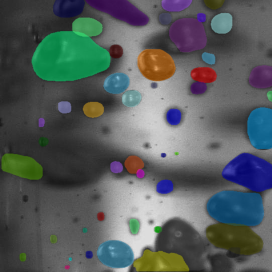

 
Image name:  300-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us2992_jpg.rf.03140de65e529658491ada288241fa98.jpg
Number of bubbles: 28
Mean bubble diameter: 3.4366
Mean bubble area: 12.2989


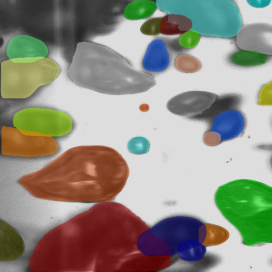

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2330_jpg.rf.1707e552360d121d50923cce85e389d7.jpg
Number of bubbles: 45
Mean bubble diameter: 2.6474
Mean bubble area: 7.4495


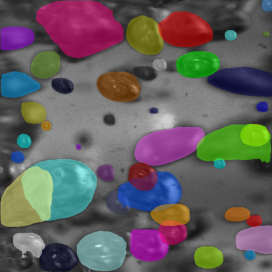

 
Image name:  400-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2738_jpg.rf.25359b26e3ddf4301ab059458bedf236.jpg
Number of bubbles: 42
Mean bubble diameter: 2.5310
Mean bubble area: 7.5258


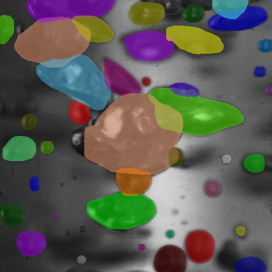

 
Image name:  400-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2858_jpg.rf.a9c7412492611426126532b196da02e2.jpg
Number of bubbles: 33
Mean bubble diameter: 2.6858
Mean bubble area: 10.4135


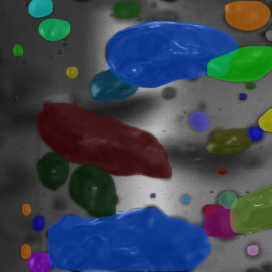

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2268_jpg.rf.f3c0a0c2dbb586942425bcdca5472f41.jpg
Number of bubbles: 55
Mean bubble diameter: 1.8970
Mean bubble area: 3.9927


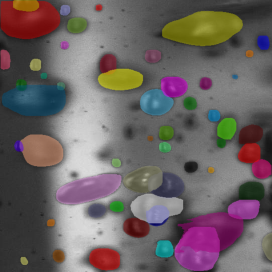

 
Image name:  300-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us2979_jpg.rf.c9d1718571fa0b701fa5b4d9457a112f.jpg
Number of bubbles: 30
Mean bubble diameter: 3.1478
Mean bubble area: 11.5996


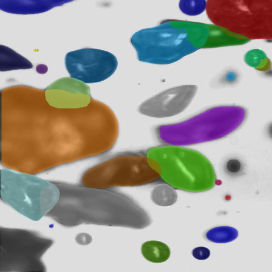

 
Image name:  400-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2776_jpg.rf.05fb9aab503f598dfe8ef330ef4e5258.jpg
Number of bubbles: 42
Mean bubble diameter: 2.9638
Mean bubble area: 8.8094


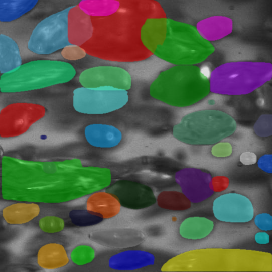

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us_2256_jpg.rf.c1893aa71ffc92df5a234e3a8aecde00.jpg
Number of bubbles: 34
Mean bubble diameter: 2.7743
Mean bubble area: 8.1425


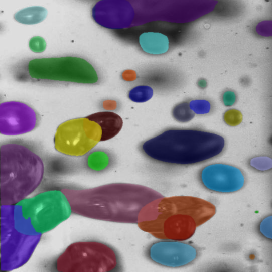

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2460_jpg.rf.07fa399b901d0faf322e7cfef50088d9.jpg
Number of bubbles: 42
Mean bubble diameter: 1.9765
Mean bubble area: 5.2805


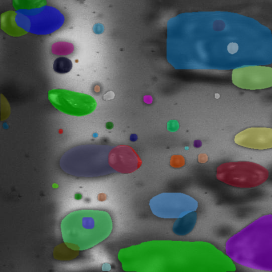

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us_2300_jpg.rf.a48543656647b294a5c690a78701a6bd.jpg
Number of bubbles: 45
Mean bubble diameter: 1.7778
Mean bubble area: 3.7199


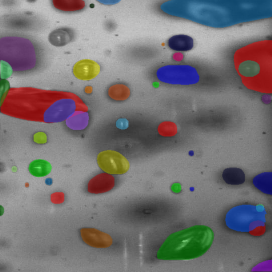

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2292_jpg.rf.7307331dea6fc224e7834cda5e842042.jpg
Number of bubbles: 29
Mean bubble diameter: 3.1056
Mean bubble area: 12.1840


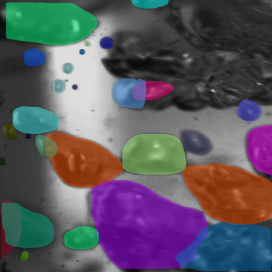

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2348_jpg.rf.a40081c188e9788e9bbcf962d4d00314.jpg
Number of bubbles: 43
Mean bubble diameter: 1.7097
Mean bubble area: 3.8879


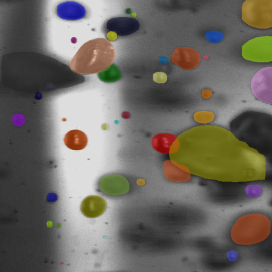

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us_2524_jpg.rf.b8a3728641ca701b704941f0a57c02a7.jpg
Number of bubbles: 47
Mean bubble diameter: 1.4781
Mean bubble area: 2.5297


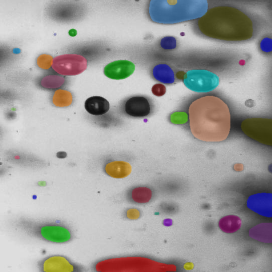

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us_2428_jpg.rf.8300467f24598027ca16f48edaa936f0.jpg
Number of bubbles: 48
Mean bubble diameter: 1.7422
Mean bubble area: 3.7310


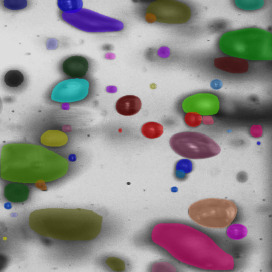

 
Image name:  400-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2834_jpg.rf.1adbce8d1a970da53fa1dfe43e965cdf.jpg
Number of bubbles: 37
Mean bubble diameter: 2.2249
Mean bubble area: 5.6196


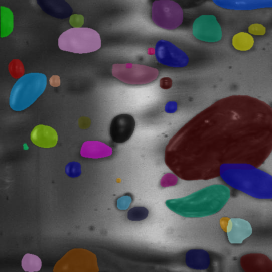

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us_2628_jpg.rf.c8afb868bd00d9e335677ca5e1b240fa.jpg
Number of bubbles: 43
Mean bubble diameter: 1.7231
Mean bubble area: 3.6681


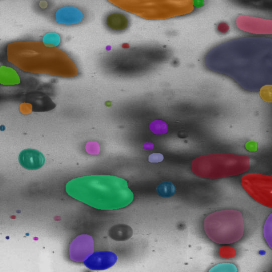

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2404_jpg.rf.28c2d0283ede971e4c397af402932119.jpg
Number of bubbles: 44
Mean bubble diameter: 1.1127
Mean bubble area: 2.1877


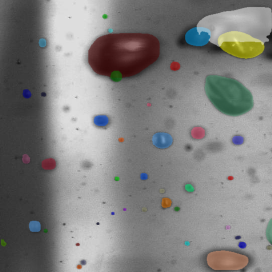

 
Image name:  300-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us2900_jpg.rf.c9433380b573aaef1c480dfd6b485da2.jpg
Number of bubbles: 32
Mean bubble diameter: 3.6403
Mean bubble area: 13.9071


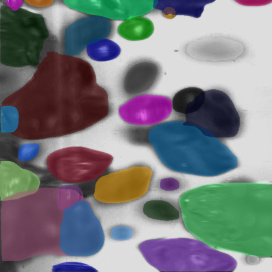

 
Image name:  400-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2754_jpg.rf.36e0961da8e86b6c4c92f64bee8fc69d.jpg
Number of bubbles: 43
Mean bubble diameter: 2.7557
Mean bubble area: 8.6856


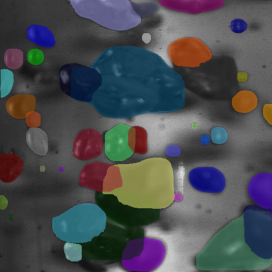

 
Image name:  13-04-s_jpg.rf.9cf5e76c2a6bca243bbe38041dd1df9c.jpg
Number of bubbles: 71
Mean bubble diameter: 1.8066
Mean bubble area: 3.1473


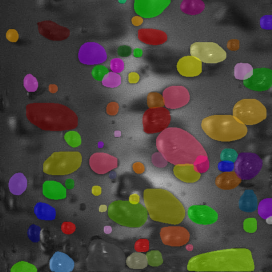

 
Image name:  3-68-s_jpg.rf.a3ae8adcbd5629954fb79ff82d86c1d1.jpg
Number of bubbles: 28
Mean bubble diameter: 1.5124
Mean bubble area: 2.5224


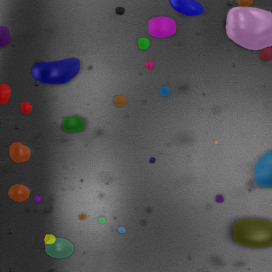

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2997_jpg.rf.971876c64bcf6b10189245fda43bd507.jpg
Number of bubbles: 46
Mean bubble diameter: 2.7003
Mean bubble area: 7.1650


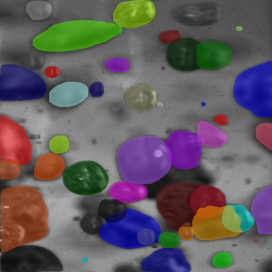

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2256_jpg.rf.54efbc8a9a081d8717742f71967510f4.jpg
Number of bubbles: 36
Mean bubble diameter: 3.0448
Mean bubble area: 9.7362


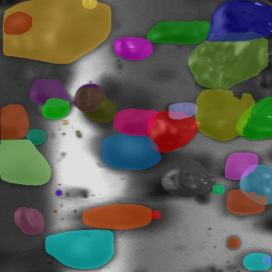

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2813_jpg.rf.bfcb03428e971aeaaf214e6f116abd53.jpg
Number of bubbles: 41
Mean bubble diameter: 2.3457
Mean bubble area: 7.3707


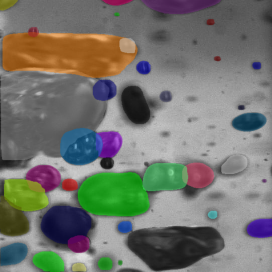

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2251_jpg.rf.6789a3de04d42bffc088849d77a68188.jpg
Number of bubbles: 41
Mean bubble diameter: 3.2028
Mean bubble area: 11.4507


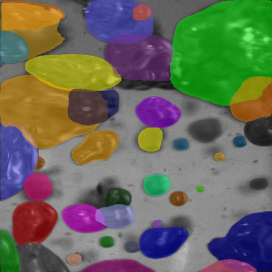

 
Image name:  100-60-s_jpg.rf.828df053129dcbf0cd4aee5dfe5584d8.jpg
Number of bubbles: 31
Mean bubble diameter: 2.6012
Mean bubble area: 7.1798


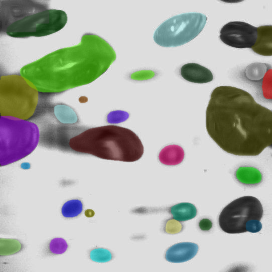

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us_2340_jpg.rf.a6295ffcba9d657ec7955a4913f5de97.jpg
Number of bubbles: 50
Mean bubble diameter: 1.7507
Mean bubble area: 3.3789


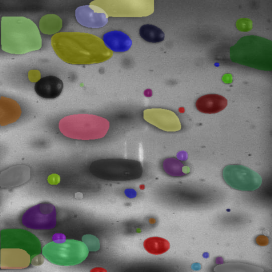

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2981_jpg.rf.454300ab24b44186dd8274b33295ad25.jpg
Number of bubbles: 41
Mean bubble diameter: 2.6630
Mean bubble area: 7.5466


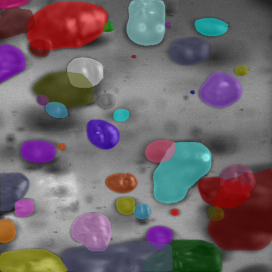

 
Image name:  400-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2720_jpg.rf.d5ab29ed2188a90aa90f24cdc7299ddc.jpg
Number of bubbles: 43
Mean bubble diameter: 2.2334
Mean bubble area: 5.2490


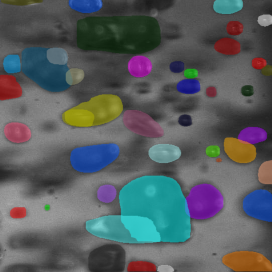

 
Image name:  10-12-s_jpg.rf.26afe5d5e7ba4d8d1e4676f180ab4e1e.jpg
Number of bubbles: 38
Mean bubble diameter: 2.5855
Mean bubble area: 7.5270


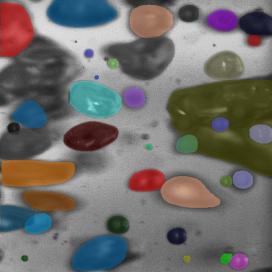

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2389_jpg.rf.ddf709218af15a36a9beaf53dba17f77.jpg
Number of bubbles: 39
Mean bubble diameter: 2.5656
Mean bubble area: 7.8196


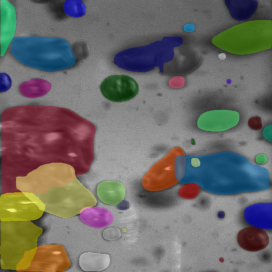

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2884_jpg.rf.42eb21532696c6064d67c86cfe3ed9c3.jpg
Number of bubbles: 43
Mean bubble diameter: 1.3509
Mean bubble area: 2.6410


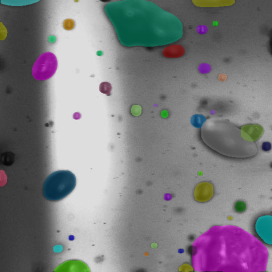

 
Image name:  400-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-333_exposure-750-us_2832_jpg.rf.3286e3d2ae0482da8dc7d556d5b9b72a.jpg
Number of bubbles: 39
Mean bubble diameter: 2.5809
Mean bubble area: 6.8686


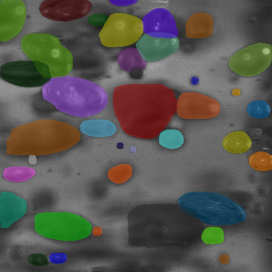

 
Image name:  300-RPM_7-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us2999_jpg.rf.96963783b8722614a9d11d68d501f467.jpg
Number of bubbles: 32
Mean bubble diameter: 2.6027
Mean bubble area: 7.3630


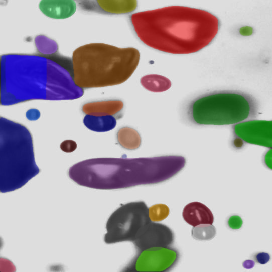

 
Image name:  300-RPM_10-5-LPM_S_D_2_H_T_2_Z_H_0-749_exposure-750-us_2468_jpg.rf.6c650ef4cc02fe382ce8a8200248268a.jpg
Number of bubbles: 47
Mean bubble diameter: 1.7161
Mean bubble area: 3.1417


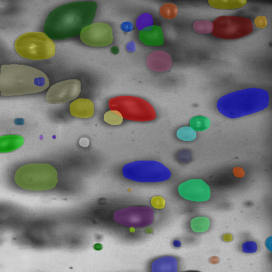

In [ ]:
import glob

print("Unit for diameter is mm and unit for area is mm^2 (If scaling line is not commented)")
for imageName in glob.glob(f'{dataset.location}/test/*'):
  simpleName = imageName.replace(f'{dataset.location}/test/','')
  if not simpleName.endswith(('.jpg', '.jpeg', '.png', '.tiff', '.tif')):
    # raise ValueError(f'File "{simpleName}" is not an image.')
    continue
  print(" ")
  print("Image name: ", simpleName)
  im = cv2.imread(imageName)
  outputs = predictor(im)
  areas = outputs["instances"].get_fields()["pred_boxes"].area()
  areasc = areas.cpu()
  areasc = areasc * scaling * scaling  # comment out if no scaling is required
  diameters = 2 * np.sqrt(areasc / np.pi)

  v = Visualizer(im[:, :, ::-1], scale=0.5)
  for mask in outputs["instances"].pred_masks.to('cpu'):
    v.draw_soft_mask(mask)
  v = v.get_output()

  print("Number of bubbles:", len(outputs["instances"]))

  print("Mean bubble diameter:", "%.4f" % diameters.mean().item())

  print("Mean bubble area:", "%.4f" % areasc.mean().item())

  cv2_imshow(v.get_image()[:, :, ::-1])

  # for i, (diameter, area) in enumerate(zip(diameters, areasc)):
  #   print(f"Bubble {i+1}: diameter = {diameter:.4f}, area = {area:.4f}")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
---------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ..

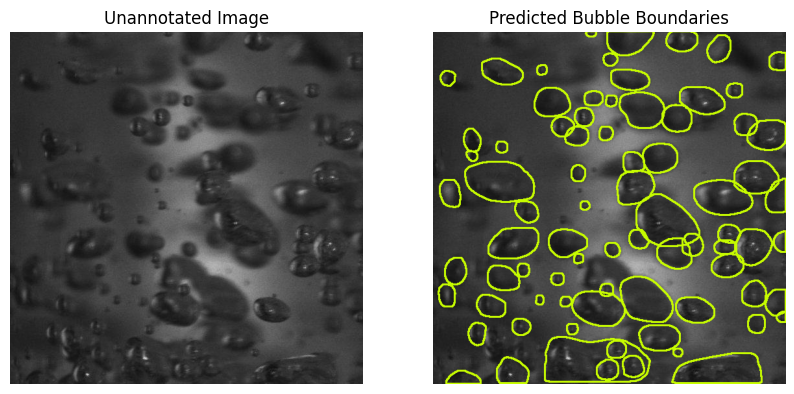

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo


# Paths
image_path = "/content/BTP_25-1/test/13-04-s_jpg.rf.9cf5e76c2a6bca243bbe38041dd1df9c.jpg"

# Load the image
image = cv2.imread(image_path)
image_height, image_width = image.shape[:2]

# Create copies of the image for visualization
unannotated_image = image.copy()

# Mask R-CNN Prediction
outputs = predictor(image)
instances = outputs["instances"].to("cpu")

# Copy image for predicted annotations visualization
predicted_image = image.copy()

# Draw Mask R-CNN predictions (only boundaries)
if len(instances) > 0:
    for i in range(len(instances)):
        # Get the mask
        mask = instances.pred_masks[i].numpy().astype(np.uint8) * 255
        print(mask)
        print("---------------")

        # Find contours of the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours on the predicted image
        cv2.drawContours(predicted_image, contours, -1, (0, 252, 199), 2)

# Save the predicted image
cv2.imwrite("predicted_image.png", predicted_image)

# Display the images side by side using matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Unannotated Image")
plt.imshow(cv2.cvtColor(unannotated_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Predicted Bubble Boundaries")
plt.imshow(cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

## Step 4: Upload images

Run the below code block and then upload the images you want to bubble detection by clicking the 'Choose files' button. <br>
The images should be preferably in jpeg format and 1:1 aspect ratio.

In [ ]:
import os
from google.colab import files

if not os.path.exists('images'):
  os.makedirs('images')

!rm -rf images/*

uploaded = files.upload()

for filename, file_content in uploaded.items():
  if not filename.endswith(('.jpg', '.jpeg', '.png', '.tiff', '.tif')):
    raise ValueError(f'File "{filename}" is not an image.')

  with open(os.path.join('images', filename), 'wb') as f:
    f.write(file_content)

  os.remove(filename)

Saving 1.92 s.jpg to 1.92 s.jpg
Saving 2.20 s.jpg to 2.20 s.jpg
Saving 3.88 s.jpg to 3.88 s.jpg
Saving 7.68 s.jpg to 7.68 s.jpg
Saving 10.20 s.jpg to 10.20 s.jpg
Saving 26.76 s.jpg to 26.76 s.jpg
Saving 27.16 s.jpg to 27.16 s.jpg
Saving 28.68 s.jpg to 28.68 s.jpg
Saving 29.52 s.jpg to 29.52 s.jpg
Saving 30.64 s.jpg to 30.64 s.jpg
Saving 31.80 s.jpg to 31.80 s.jpg
Saving 34.44 s.jpg to 34.44 s.jpg
Saving 34.60 s.jpg to 34.60 s.jpg
Saving 45.24 s.jpg to 45.24 s.jpg
Saving 50.60 s.jpg to 50.60 s.jpg
Saving 53.28 s.jpg to 53.28 s.jpg
Saving 55.84 s.jpg to 55.84 s.jpg
Saving 58.36 s.jpg to 58.36 s.jpg
Saving 58.56 s.jpg to 58.56 s.jpg
Saving 70.48 s.jpg to 70.48 s.jpg
Saving 72.92 s.jpg to 72.92 s.jpg
Saving 73.68 s.jpg to 73.68 s.jpg
Saving 80.04 s.jpg to 80.04 s.jpg
Saving 81.68 s.jpg to 81.68 s.jpg
Saving 90.64 s.jpg to 90.64 s.jpg
Saving 90.68 s.jpg to 90.68 s.jpg
Saving 92.04 s.jpg to 92.04 s.jpg
Saving 92.24 s.jpg to 92.24 s.jpg
Saving 93.00 s.jpg to 93.00 s.jpg
Saving 99.92 s.jpg to 

In [ ]:
import glob

print("Unit for diameter is mm and unit for area is mm^2 (If scaling line is not commented)")
diam_coll = []

i=0
for imageName in glob.glob('/content/images/*'):
  simpleName = imageName.replace('/content/images/','')
  if not simpleName.endswith(('.jpg', '.jpeg', '.png', '.tiff', '.tif')):
    continue
  print(" ")
  print("Image name: ", simpleName)
  im = cv2.imread(imageName)
  outputs = predictor(im)
  areas = outputs["instances"].get_fields()["pred_boxes"].area()
  areasc = areas.cpu() * scaling * scaling  # comment out if no scaling is required
  diameters = 2 * np.sqrt(areasc / np.pi)

  i += len(diameters)
  diam_coll.extend(diameters.tolist())


print("Number of bubbles", i)

Unit for diameter is mm and unit for area is mm^2 (If scaling line is not commented)
 
Image name:  43.44 s.jpg
 
Image name:  173.40 s.jpg
 
Image name:  128.88 s.jpg
 
Image name:  169.56 s.jpg
 
Image name:  67.32 s.jpg
 
Image name:  37.48 s.jpg
 
Image name:  148.32 s.jpg
 
Image name:  197.16 s.jpg
 
Image name:  110.36 s.jpg
 
Image name:  80.68 s.jpg
 
Image name:  149.20 s.jpg
 
Image name:  54.04 s.jpg
 
Image name:  6.72 s.jpg
 
Image name:  38.72 s.jpg
 
Image name:  114.68 s.jpg
 
Image name:  46.60 s.jpg
 
Image name:  69.92 s.jpg
 
Image name:  119.36 s.jpg
 
Image name:  129.56 s.jpg
 
Image name:  57.16 s.jpg
 
Image name:  129.48 s.jpg
 
Image name:  172.04 s.jpg
 
Image name:  182.92 s.jpg
 
Image name:  139.36 s.jpg
 
Image name:  98.40 s.jpg
 
Image name:  105.28 s.jpg
 
Image name:  69.00 s.jpg
 
Image name:  123.88 s.jpg
 
Image name:  23.88 s.jpg
 
Image name:  109.40 s.jpg
 
Image name:  131.80 s.jpg
 
Image name:  82.76 s.jpg
 
Image name:  21.56 s.jpg
 
Image

In [ ]:
print(len(diam_coll))
print(np.mean(diam_coll))

1639
3.422672786404986


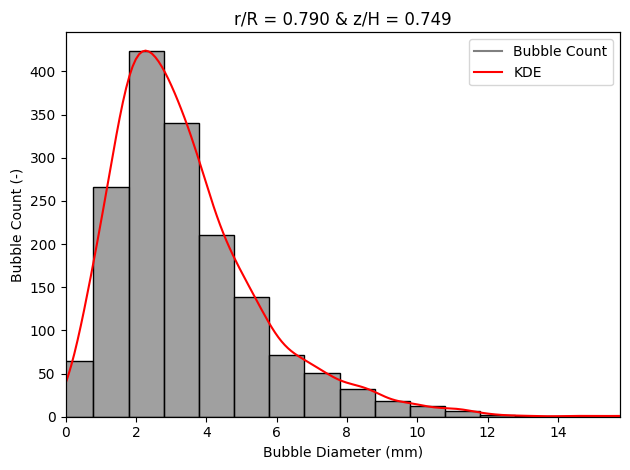

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for demonstration (replace diam_coll with actual data)
bubble_diam = np.array(diam_coll)  # Example data

# Create DataFrame
df = pd.DataFrame(bubble_diam, columns=["Bubble Diameter (mm)"])

# Create figure and main axis for histogram
fig, ax1 = plt.subplots()

# Plot histogram with count on the left axis, setting color to gray
sns.histplot(data=df, x="Bubble Diameter (mm)", discrete=True, color="gray", ax=ax1)
ax1.set_ylabel("Bubble Count (-)")
ax1.set_xlim((0, df["Bubble Diameter (mm)"].max()))

# Create twin axis for KDE, set color to red, and hide its y-axis
ax2 = ax1.twinx()
sns.kdeplot(data=df, x="Bubble Diameter (mm)", color="red", ax=ax2)
ax2.yaxis.set_visible(False)

# Manually add a combined legend in the top-right corner
hist_patch = plt.Line2D([], [], color="gray", label="Bubble Count")
kde_line = plt.Line2D([], [], color="red", label="KDE")
ax1.legend(handles=[hist_patch, kde_line], loc="upper right")

# Set title and save the figure
plt.title("r/R = 0.790 & z/H = 0.749")
plt.tight_layout()
plt.savefig("bubble_diameter_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

#----------------------------------------END--------------------------------------------